In [1]:
from sklearn.utils import all_estimators
import numpy as np
import pandas as pd
import os
import itertools
from IPython.display import clear_output
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
sns.set_style('darkgrid')

In [9]:
P = (2000*2000*1000)/(3600*24*365)

In [10]:
V = 45

In [12]:
Evap = P-V; Evap

81.83916793505834

In [14]:
C = V/P; C

0.35478000000000004

In [16]:
Evap*3600*24*365*1000/(2000*1e6)

1290.4399999999998

In [21]:
V_mm = 20*3600*24*365*1e-6; V_mm

630.72

In [ ]:
V_mm = 

#### Interpolação Polinomial

In [2]:
def interpol(x, y, xlim=None, ylim=None, plot=False):

    x, y = np.array(x), np.array(y)
    n = len(x)
    A = np.transpose([x**(n-1-i) for i in range(n)])
    a = np.linalg.inv(A).dot(y)
    
    interval = max(x) - min(x)
    x_min = min(x) - interval/20
    x_max = max(x) + interval/20
    xx = np.linspace(x_min, x_max)
    
    if plot:
        plt.plot(x, y, 'ro', xx, np.polyval(a, xx), 'b-')
        plt.show()
    else:
        return a

In [3]:
def interpol_groups_inter(n_members_df0, n_members=2, x_col='n top colunas mais importantes', xlim=None, ylim=None):
    
    n_members_df = n_members_df0[n_members_df0['n_members']==n_members]
    groups = n_members_df['group'].unique()
    n_grps=len(groups)
    
    fig = plt.figure(figsize=(14,9))
    axs = [fig.add_subplot(3,2,i) for i in range(1,6)]
    for i, col in enumerate(n_members_df.columns[3:]):

        
        cnt_grp=1
        
        for group in groups:
            
            clear_output(wait=True)
            print('Desenhando Variável {}/{} - Grupo {}/{}'.format(i+1, 5, cnt_grp, n_grps))
           
            group_df = n_members_df[n_members_df['group']==group]
            
            x = np.array(group_df[x_col])
            xx = np.linspace(x.min(), x.max(), 3000)
            y = np.array(group_df[col])
            
            
            coef = interpol(x, y)
            y_pred = np.polyval(coef, xx)
            
            axs[i].plot(xx, y_pred)
            cnt_grp+=1
            
        
        axs[i].legend([])
        axs[i].set(xlim=xlim, ylim=ylim, title=col)
        axs[i].grid()
        
    plt.show()
    plt.pause(0.1)


In [4]:
def groups_inter(n_members_df0, n_members=2, x_col='n top colunas mais importantes', xlim=None, ylim=None, figsize=(14,15)):
    
    n_members_df = n_members_df0[n_members_df0['n_members']==n_members]
    groups = n_members_df['group'].unique()
    n_grps=len(groups)
    
    fig = plt.figure(figsize=figsize)
    axs = [fig.add_subplot(3,2,i) for i in range(1,6)]
    for i, col in enumerate(n_members_df.columns[3:]):

        
        cnt_grp=1
        
        for group in groups:
            
            clear_output(wait=True)
            print('Desenhando Variável {}/{} - Grupo {}/{}'.format(i+1, 5, cnt_grp, n_grps))
            n_members_df[n_members_df['group']==group].plot(x_col, col, ax=axs[i])
            cnt_grp+=1
            
        
        axs[i].legend([])
        axs[i].set(xlim=xlim, ylim=ylim, title=col)
        axs[i].grid()
        
    plt.show()
    plt.pause(0.1)

def members_inter(n_members_df, x_col='n top colunas mais importantes', xlim=None, ylim=None):
    
    fig = plt.figure(figsize=(14,9))

    axs = [fig.add_subplot(3,2,i) for i in range(1,6)]

    for i, col in enumerate(n_members_df.columns[3:]):

        clear_output(wait=True)
        
        for member in range(2, n_members_df['n_members'].max()+1):
            
            #n_members_df.groupby(['n_members', x_col]).mean().reset_index()
            n_members_df[n_members_df['n_members']==member].groupby([x_col]).mean().reset_index().plot(x_col, col, ax=axs[i])
        
        axs[i].legend([])
        axs[i].set(xlim=xlim, ylim=ylim, title=col)
        axs[i].grid()
        
    plt.show()
    plt.pause(0.1)

In [5]:
def intersection(lists):
    a=set(lists[0])
    for i in range(1,len(lists)):
        a = a.intersection(lists[i])
    return a

def n_top_intersection_analysis(top_lists):
    
    n_lists = len(top_lists)
    n_top_max = len(top_lists[0])    
    len_inter = []
    for i in range(1, n_top_max+1):
        
        top_lists_n = [top_lists[j][:i] for j in range(n_lists)]
        
        inter = len(intersection(top_lists_n))
        ttl=len(np.unique(np.array(top_lists_n)))
        len_inter.append([i, inter, inter/i, ttl, inter/ttl, ttl/i])

    len_inter_df = pd.DataFrame(len_inter, columns=['n top colunas mais importantes', 'interseção', 'interseção por n top',
                                                    'colunas unicas', 'interseção por colunas unicas', 'colunas unicas por n top'])
    return len_inter_df

def n_members_intersection_analysis(top_lists_org, n_members=2, rank_degree=2, rank_step=1):
       
    n_lists_org = len(top_lists_org)
    n_top_max = len(top_lists_org[0])    
    
    groups = list(itertools.combinations(range(n_lists_org), n_members))
    n_groups = len(groups)
    groups_stats = []
    cnt_grp = 0
    
    for group in groups:
              
        
        top_lists = [top_lists_org[member] for member in group]
        n_lists = len(top_lists)

        
        loop = np.array(range(rank_step, n_top_max+1, rank_step))**rank_degree
        stop=0
        for i in loop:
    
            if i>=n_top_max+1:
                stop+=1
                i = n_top_max+1
                if stop==2: break

            clear_output(wait=True)
            print('Grupo {}/{} - {}/{}'.format(cnt_grp, n_groups, i, n_top_max))
                 
            top_lists_n = [top_lists[j][:i] for j in range(n_lists)]

            inter = len(intersection(top_lists_n))
            unique = len(np.unique(np.array(top_lists_n)))

            groups_stats.append([group, n_members, i, inter, inter/i, unique, inter/unique, unique/i])
        
        cnt_grp+=1

    groups_df = pd.DataFrame(groups_stats, columns=['group', 'n_members', 'n top colunas mais importantes', 'interseção', 'interseção por n top',
                                                        'colunas unicas', 'interseção por colunas unicas', 'colunas unicas por n top'])
    
    return groups_df

def n_top_combinations_intersection_analyses(top_lists_org, max_members, member_step, rank_degree=2, rank_step=1):
    
    n_members_lst = []
    for n_members in range(2, max_members+1, member_step):
        
        n_stats = n_members_intersection_analysis(top_lists_org, n_members=n_members, rank_degree=rank_degree, rank_step=rank_step)
        n_members_lst.append(n_stats)
    
    n_members_df = pd.concat(n_members_lst, axis=0)
    
    return n_members_df

In [6]:
def simple_groups_inter(n_members_df0, cols=None, n_members=2, x_col='n top colunas mais importantes', figsize=(25,15), xlim=None, ylim=None, colors=None, legend=[]):
    
    if cols==None: cols = n_members_df0.columns[3:-1].tolist()
    n_members_df = n_members_df0[n_members_df0['n_members']==n_members]    
    groups = n_members_df['group'].unique()
    n_grps=len(groups)
    if type(colors)==type(None): colors=[None]*n_grps
   
    fig = plt.figure(figsize=figsize)
    axs = [fig.add_subplot(3,2,i) for i in range(1,len(cols)+1)]
    for i, col in enumerate(cols):
        
        cnt_grp=1
        
        for group, color in zip(groups, colors):
            
            clear_output(wait=True)
            print('Desenhando Variável {}/{} - Grupo {}/{}'.format(i+1, len(cols), cnt_grp, n_grps))
            n_members_df[n_members_df['group']==group].plot(x_col, col, ax=axs[i], color=color)
            cnt_grp+=1
            
        
        axs[i].legend(legend)
        axs[i].set(xlim=xlim, ylim=ylim, title=col)
        axs[i].grid()
        
    plt.show()
    plt.pause(0.1)

In [7]:
from IPython.display import clear_output
from ipywidgets import widgets

In [21]:
widgets.IntSlider(1)
#clear_output()
# Note that `clear_output` will not clear widgets displayed using `display(widgets.IntSlider(1))`
#widgets.IntSlider(100)

IntSlider(value=1)

### Recarregando Ranks

In [8]:
ranks_path = 'Feature Selection/Ranks/'

ranks_files = os.listdir(ranks_path)

ranks_lst = [pd.read_csv(ranks_path+rank_file, index_col=0) for rank_file in ranks_files]

OSError: Initializing from file failed

In [ ]:
coef_names = [col[:-4] for col in ranks_files]

In [ ]:
ranks_df = pd.concat(ranks_lst, axis=1)
ranks_df.columns = coef_names[:]

# Ranks Analysis

### Ordenando Ranks Carregados

In [ ]:
sorted_ranks_lst = [rank.reset_index().sort_values(['0', 'index'])['index'].tolist() for rank in ranks_lst]

### Análise do Número de Combinações para grupos de tamanho n

In [ ]:
n_items = list(range(1, len(coef_names)+1))

n_combs = [len(list(itertools.combinations(n_items, i))) for i in n_items[1:]]

plt.bar(n_items[1:], n_combs)
plt.xticks(n_items[1:])
plt.grid()
plt.show()

# Análise da interseção para combinações de 2 (COMPLETA)

In [249]:
members_2 = n_members_intersection_analysis(top_lists_org = sorted_ranks_lst, n_members=2, rank_step=1, rank_degree=1)

Grupo 152/153 - 8819/8819


In [253]:
from datetime import datetime

In [254]:
members_2.to_csv('Feature Selection/análise_interseção_combinações_de2_ranks_completa.csv')
print(datetime.now())

2021-04-01 15:24:58.109669


In [255]:
members_2.shape

(1349307, 8)

In [259]:
members_2

,group,n_members,n top colunas mais importantes,interseção,interseção por n top,colunas unicas,interseção por colunas unicas,colunas unicas por n top
0,"(0, 1)",2,1,0,0.000000,2,0.000000,2.000000
1,"(0, 1)",2,2,0,0.000000,4,0.000000,2.000000
2,"(0, 1)",2,3,0,0.000000,6,0.000000,2.000000
3,"(0, 1)",2,4,0,0.000000,8,0.000000,2.000000
4,"(0, 1)",2,5,0,0.000000,10,0.000000,2.000000
...,...,...,...,...,...,...,...,...
1349302,"(16, 17)",2,8815,8811,0.999546,8819,0.999093,1.000454
1349303,"(16, 17)",2,8816,8813,0.999660,8819,0.999320,1.000340
1349304,"(16, 17)",2,8817,8815,0.999773,8819,0.999546,1.000227
1349305,"(16, 17)",2,8818,8817,0.999887,8819,0.999773,1.000113


Desenhando Variável 5/5 - Grupo 153/153


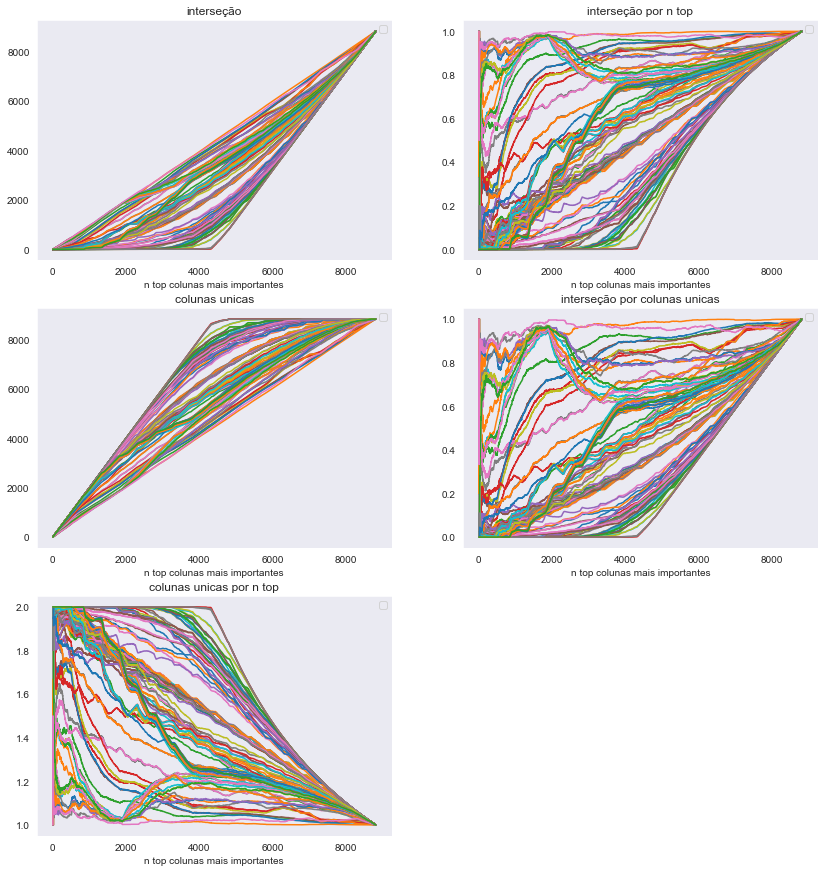

In [265]:
groups_inter(members_2)

Desenhando Variável 5/5 - Grupo 153/153


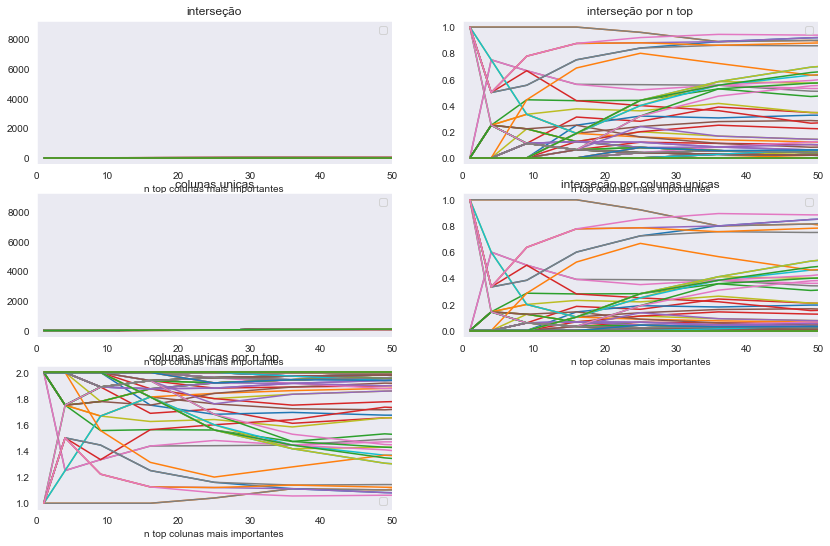

In [35]:
groups_inter(members_2, xlim=(0,50))

Desenhando Variável 5/5 - Grupo 153/153


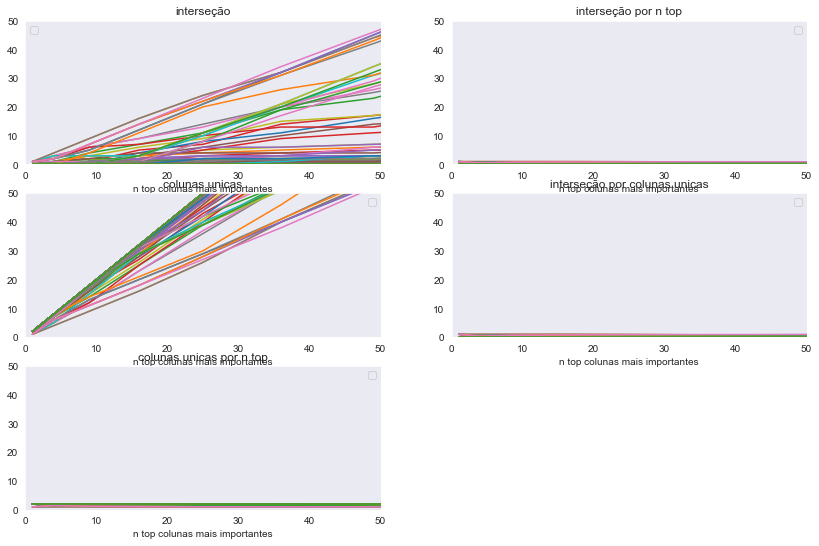

In [36]:
groups_inter(members_2, xlim=(0,50), ylim=(0,50))

# OVERSAMPLING

# IMPORTANDO BIBLIOTECAS

#### Computação Científica

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

from IPython.display import clear_output
import time
from datetime import datetime
import itertools

sns.set_style('darkgrid')

#### Machine Learning: Classificação

In [9]:
import sklearn
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as TREE, DecisionTreeRegressor as TREE_reg
from sklearn.linear_model import LogisticRegression as LogReg, SGDClassifier as SGDC
from sklearn.svm import SVC, SVR
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.gaussian_process import GaussianProcessClassifier as GPC
from sklearn.ensemble import BaggingClassifier as BGG, RandomForestClassifier as RFC, ExtraTreesClassifier as ETC, StackingClassifier as STCK, GradientBoostingClassifier as GBC, AdaBoostClassifier as ABC, VotingClassifier as Voting
from sklearn.ensemble import BaggingRegressor as BGG_reg, RandomForestRegressor as RFR, ExtraTreesRegressor as ETR, AdaBoostRegressor as ABR

from sklearn.preprocessing import LabelEncoder as le, StandardScaler as ss, MinMaxScaler as mms
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedShuffleSplit as sss, train_test_split
from sklearn.metrics import accuracy_score as acc_scr, r2_score, classification_report, confusion_matrix, make_scorer

scorer = make_scorer(acc_scr)

from sklearn.metrics import accuracy_score as acc_scr
from sklearn.metrics import matthews_corrcoef 
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score, precision_recall_fscore_support

from sklearn.preprocessing import LabelBinarizer

In [779]:
def score_betas(y_test, y_pred, betas):
    
    fbeta_scrs=[]
    for beta in betas:
        fbeta_scrs.append(fbeta_score(y_test, y_pred, beta=beta))

    return pd.Series(fbeta_scrs, index=betas)

def scr_models(train_set, test_set=None, target='TX_RESP_Q050', models=None,
               names=None, params_list=None,
               method='classes', keep_params=False,
               clear=True, score_fbeta=False, betas=list(np.linspace(0,1,10)), triple=False,
              path=None):
    
    n_models=len(models)
    if type(params_list)==type(None): params_list = [{}]*n_models

    rows = []
    cnt=1
    for model, name, params in zip(models, names, params_list):

        if clear: clear_output(wait=True)
        print('\nAvaliando Modelo {} - ({}/{})'.format(name, cnt, n_models))
        
        if triple:
                
            row = scr_triple(train_set, test_set, target, model, name, params, method, score_fbeta=score_fbeta, betas=betas)
        else:
            
            row = scr(train_set, test_set, target, model, name, params, method, score_fbeta=score_fbeta, betas=betas)
            if type(path)!=type(None):
                row.to_csv(path.format(name))
            
            
        rows.append(row)
        cnt+=1

    scrs_df = pd.concat(rows, axis=1).T
    if keep_params: 
        params_df = pd.DataFrame(params)
        scrs_df = pd.concat([scrs_df, params_df], axis=1)
        
    return scrs_df

def scr(train_set, test_set=None, target='TX_RESP_Q050', model=None, name=None, params={}, method='classes', score_fbeta=False, betas=list(np.linspace(0,1,10)), verbose=1):

    if verbose>=2: print('\nExtraindo X e Y...')
    features = [col for col in train_set.columns.tolist() if col!= target]
    x_train, y_train = train_set[features], train_set[target]
    if type(test_set) != type(None): x_test, y_test = test_set[features], test_set[target]

    scrs = []
    cols = [ 'accuracy',
             'matthews corrcoef',
             'precision - 0',
             'recall - 0',
             'f1-score - 0',
             'precision - 1',
             'recall - 1',
             'f1-score - 1',
             'precision - macro avg',
             'recall - macro avg',
             'f1-score - macro avg',
             'precision - weighted avg',
             'recall - weighted avg',
             'f1-score - weighted avg' ]

    if method=='cross_val_score': 
        print('Cross-Validating Model {}...'.format(name))
        scrs += cross_val_score(model(**params), x_train, y_train)
        cols = ['acc {}'.format(i) for i in range(1,6)]

    else:
        if verbose >= 1: print('\nConstruindo Modelo {}...'.format(name))
        new_model = model(**params)
        if verbose >= 1: print('Fitting...')
        new_model.fit(x_train, y_train)
        if verbose >= 1: print('Predicting...')
        y_pred = new_model.predict(x_test)
        if verbose >= 1: print('Scoring...')
        matthews = matthews_corrcoef(y_test, y_pred)        
        class_report = classification_report(y_test, y_pred, output_dict=True)
        class_scrs = [class_report['accuracy'], matthews] + list(class_report['0'].values())[:-1] + list(class_report['1'].values())[:-1] + list(class_report['macro avg'].values())[:-1] + list(class_report['weighted avg'].values())[:-1]
        
        scrs += class_scrs
 
    scrs = pd.Series(scrs, index=cols, name=name)
    
    if score_fbeta:
        beta_scrs = score_betas(y_test, y_pred, betas)
        beta_scrs.name=name
        scrs = pd.concat([scrs, beta_scrs], axis=0)
        
    return scrs
    

def scr_triple(train_set, test_set=None, target='TX_RESP_Q050', model=None, name=None, params={}, method='classes', score_fbeta=False, betas=list(np.linspace(0,1,10))):

    print('Extraindo X e Y...')
    features = [col for col in train_set.columns.tolist() if col!= target]
    x_train, y_train = train_set[features], train_set[target]
    if type(test_set) != type(None): x_test, y_test = test_set[features], test_set[target]

    scrs = []
    cols = [ 'accuracy',
             'matthews corrcoef',
             'precision - 0',
             'recall - 0',
             'f1-score - 0',
             'precision - 1',
             'recall - 1',
             'f1-score - 1',
             'precision - 2',
             'recall - 2',
             'f1-score - 2',
             'precision - macro avg',
             'recall - macro avg',
             'f1-score - macro avg',
             'precision - weighted avg',
             'recall - weighted avg',
             'f1-score - weighted avg' ]

    if method=='cross_val_score': 
        print('Cross-Validating Model {}...'.format(name))
        scrs += cross_val_score(model(**params), x_train, y_train)
        cols = ['acc {}'.format(i) for i in range(1,6)]

    else:
        print('Construindo Modelo {}...'.format(name))
        new_model = model(**params)
        print('Fitting...')
        new_model.fit(x_train, y_train)
        print('Predicting...')
        y_pred = new_model.predict(x_test)
        print('Scoring...')
        matthews = matthews_corrcoef(y_test, y_pred)        
        class_report = classification_report(y_test, y_pred, output_dict=True)
        class_scrs = [class_report['accuracy'], matthews] + list(class_report['0'].values())[:-1] + list(class_report['1'].values())[:-1] + list(class_report['2'].values())[:-1] + list(class_report['macro avg'].values())[:-1] + list(class_report['weighted avg'].values())[:-1]
        
        scrs += class_scrs
 
    scrs = pd.Series(scrs, index=cols, name=name)
    
    if score_fbeta:
        beta_scrs = score_betas(y_test, y_pred, betas)
        beta_scrs.name=name
        scrs = pd.concat([scrs, beta_scrs], axis=0)
        
    return scrs
    

def score_sets(sets, sets_names, target, models, names, params_list=None, method='classes', save=False, path=None, index=True):
    scrs = []
    cnt=0
    for (train, test), set_name in zip(sets, sets_names):

        clear_output(wait=True)
        print('Scoring Set: ', cnt+1, '/ {}'.format(len(sets)))

        new_scr = scr_models(train, test, target, models, names, params_list, method=method, clear=False)
        new_scr['set']=set_name
        
        if save:
            new_scr.to_csv(path+set_name+'.csv', index=index)
        
        scrs.append(new_scr)
        cnt+=1
        
    scrs_df = pd.concat(scrs, axis=0)
    #scrs_df['Set']=[set_name for j in range(len(models)) for set_name in sets_names]
    
    clear_output(wait=False)
    print('DONE!')
    return scrs_df

In [782]:
def list_sets(train_set, test_set, target, keep_list):
    sets = []
    for keep in keep_list:
        cols = keep + [target]
        sets.append([train_set[cols], test_set[cols]])
    
    print('Sets Shapes::')
    [print(set_i[0].shape, set_i[1].shape) for set_i in sets]
    
    return sets

def score_sets(sets, sets_names, target, models, names, params_list=None, method='classes', save=False, path=None, index=True):
    scrs = []
    cnt=0
    for (train, test), set_name in zip(sets, sets_names):

        clear_output(wait=True)
        print('Scoring Set: ', cnt+1, '/ {}'.format(len(sets)))

        new_scr = scr_models(train, test, target, models, names, params_list, method=method, clear=False)
        new_scr['set']=set_name
        
        if save:
            new_scr.to_csv(path+set_name+'.csv', index=index)
        
        scrs.append(new_scr)
        cnt+=1
        
    scrs_df = pd.concat(scrs, axis=0)
    #scrs_df['Set']=[set_name for j in range(len(models)) for set_name in sets_names]
    
    clear_output(wait=False)
    print('DONE!')
    return scrs_df

def heatmap_scrs(sets_scrs, key='set', cols=None, figsize=(5,6), vmin=0.45, vmax=0.8):

    names = sets_scrs.index.unique().tolist()
    if type(cols)==type(None): 
        cols = [ 'accuracy',
                 'matthews corrcoef',
                 'precision - 0',
                 'recall - 0',
                 'f1-score - 0',
                 'precision - 1',
                 'recall - 1',
                 'f1-score - 1',
                 'precision - macro avg',
                 'recall - macro avg',
                 'f1-score - macro avg',
                 'precision - weighted avg',
                 'recall - weighted avg',
                 'f1-score - weighted avg' ]

    for name in names:
        if input('Next Model: {}'.format(name))=='exit':break

        fig, axs = plt.subplots(figsize=figsize)
        sns.heatmap(sets_scrs.set_index(key, append=True).loc[name].T.loc[cols], annot=True, ax=axs, vmin=vmin, vmax=vmax, fmt='.3g')

        plt.show()
        plt.pause(0.01)
        clear_output(wait=True)


def scrs_prog(sets_df, key='set', cols=None, figsize=(16,3), xlim=None, ylim=None, full=False, marker=None):
    
    for col in sets_df.index.unique():
        
        if not full:
            if input('Ver próximo? {}'.format(col))=='exit': break 
            
        fig, axs = plt.subplots(1, len(cols), figsize=figsize)
        for i, col_lst in enumerate(cols):
            sets_df.loc[col].set_index(key)[col_lst].plot(ax=axs[i], marker=marker)
            axs[i].set(xlim=xlim, ylim=ylim, title='{} - {}'.format(col, list(range(len(cols)))[i]))
            

        plt.show()
        plt.pause(0.01)
        if not full: clear_output(wait=True)
        
        

def heatmap(scrs, cols=None, titles=['Geral', 'Classe 0', 'Classe 1', 'Médias'], beta_cols=list(np.linspace(0,1,10)), figsize=(15,5), vmin=0.3, vmax=0.8, beta=False, betas_figsize=(15,5)):
    
    
    if type(cols)==type(None): 
        
        acc = scrs.columns[:2]
        cls_acc = scrs.columns[2:8]
        avg_acc = scrs.columns[8:14]

        cols=[acc, cls_acc[:3], cls_acc[3:], avg_acc]

    
    fig, axs = plt.subplots(1, len(cols), figsize=figsize)
    for i, cols in enumerate(cols):
        sns.heatmap(scrs[cols], ax=axs[i], annot=True, vmax=vmax, vmin=vmin, cbar=(True if i==3 else False))
        axs[i].set_title(titles[i])
        if i>0: axs[i].set_yticklabels([])
        
    plt.show()
    plt.pause(0.01)
    
    if beta:
        fig, axs = plt.subplots(1, 1, figsize=betas_figsize)
        sns.heatmap(scrs[beta_cols], annot=True)
        axs.set_title('Scores f-beta')
        plt.show()

### Atualizado

In [338]:
def heatmap_scrs(sets_scrs, key='set', cols=None, figsize=(5,6), vmin=0.45, vmax=0.8, break_cols=False):

    names = sets_scrs.index.unique().tolist()
    if type(cols)==type(None): 
        cols = [ 'accuracy',
                 'matthews corrcoef',
                 'precision - 0',
                 'recall - 0',
                 'f1-score - 0',
                 'precision - 1',
                 'recall - 1',
                 'f1-score - 1',
                 'precision - macro avg',
                 'recall - macro avg',
                 'f1-score - macro avg',
                 'precision - weighted avg',
                 'recall - weighted avg',
                 'f1-score - weighted avg' ]
    
    if break_cols:
        loop_cols = [cols[:2], cols[2:5],
                     cols[5:8], cols[8:]]
        
    for name in names:
        
        if input('Next Model: {}'.format(name))=='exit': break    
        df = sets_scrs.set_index(key, append=True).loc[name].T.loc[cols]
        
        if break_cols:
            
            fig, axs = plt.subplots(1, len(loop_cols), figsize=figsize)
            
            df = df.T
            for i, l_cols in enumerate(loop_cols):
                sns.heatmap(df[l_cols], annot=True, vmin=vmin, vmax=vmax, fmt='.3g', ax=axs[i], cbar=(True if i==len(loop_cols)-1 else False))
                if i>0: axs[i].set_yticklabels([])
            
        else:
            fig, axs = plt.subplots(figsize=figsize)
            sns.heatmap(df, annot=True, ax=axs, vmin=vmin, vmax=vmax, fmt='.3g')
            
            
        plt.show()
        plt.pause(0.01)
        clear_output(wait=True)

In [11]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))


In [12]:
def filtrar_categorias(df, target, ctgr_lst, replace_dict=None, encode=False):
    
    print('Construindo Index...')       # Selecionando index onde alvo em 'ctgr_lst'
    new_index=[]
    for ctgr in ctgr_lst:
        new_index += df[df[target]==ctgr].index.tolist()
    
    print('Extraindo Dados da Tabela...')      # Extraindo tabela com index construído
    df = df.loc[new_index]    
    
    if type(replace_dict)!=type(None):
        print('Substituindo Categorias: {}'.format(replace_dict))      # Fusão de categorias
        for key in replace_dict.keys():
            df[target] = df[target].replace(key, replace_dict[key])
    
    if encode:
        print('Rotulando Variável Alvo...')
        df[target] = le().fit(df[target]).transform(df[target])      # Rotulando variável alvo
        
    print('\nCategorias Atualizadas!')
    return df

In [684]:
def binary_sample(df, target, categories=[[0], [1]],
                  testing=[1000, 1000], training=[5000, 5000],
                  fill_train_1=False, equal_train_0=False,
                  test_set=None, print_shapes=False, invert=False):
    
    if invert:
        training=testing.copy()
        testing=[None, None]
    
    print('Extraindo Index por Categoria...')
    index_0 = df[df[target].isin(categories[0])].index
    index_1 = df[df[target].isin(categories[1])].index
        
    if type(test_set)==type(None):
        return_test=True
        print('Extraindo Index Teste - {} para {}...'.format(testing[0], testing[1]))
        test_index = list(np.random.choice(index_0, testing[0], replace=False)) + list(np.random.choice(index_1, testing[1], replace=False))
        print('Extraindo Tabela de Teste...')
        test_set = df.loc[test_index]
    
    else:
        return_test=False
        test_index = test_set.index.tolist()        
    
    print('Extraindo Index Treinamento (Excluindo Index Teste) - {} para {}...'.format(training[0], training[1]))  
    
    index_1_train = list(set(index_1).difference(test_index))   # Está Invertido (1 depois 0)
    if not fill_train_1: index_1_train = list(np.random.choice(index_1_train, training[1], replace=False))
    
    index_0_train = list(set(index_0).difference(test_index))
    if equal_train_0: training[0] = len(index_1_train)
    index_0_train = list(np.random.choice(index_0_train, training[0], replace=False))
    
    train_index = index_0_train + index_1_train
    
    print('Extraindo Tabela de Treinamento...')
    train_set = df.loc[train_index]    
        
    clear_output(wait=True)
    if print_shapes:
        print('Original Shape:')
        print(ano9_base.shape)
        print('Test Set Shape:')
        print(test_set.shape)
        print('Train Set Shape:')
        print(train_set.shape)
        print('')

    
    sets = [df, train_set, test_set]
    report_cols = ['Original', 'Treinamento', 'Teste']
    
    print('Contagem Categorias:')
    if invert: 
        report_cols[1], report_cols[2] = report_cols[2], report_cols[1]

    relatorio_amostragem = pd.concat([data_set[target]
                                      .value_counts()
                                      .to_frame()
                                      .rename(columns={target:col_name}) for data_set, col_name in zip(sets, report_cols)], axis=1)
    
    display(relatorio_amostragem)
   
    inter = set(train_set.index).intersection(test_set.index)
    if inter: print('\nInformação Vazada para Tabela de Treinamento')
    else: print('\nNenhum Aluno em Comum nas Tabelas de Treinamento e Teste')

    if not return_test: return train_set
    return train_set, test_set

In [317]:
def heatmap(scrs, cols=None, titles=['Geral', 'Classe 0', 'Classe 1', 'Médias'],
            beta_cols=list(np.linspace(0,1,10)), figsize=(15,5), vmin=0.3, vmax=0.8,
            beta=False, betas_figsize=(15,5), invert=False):
    
    
    if type(cols)==type(None): 
        
        acc = scrs.columns[:2]
        cls_acc = scrs.columns[2:8]
        avg_acc = scrs.columns[8:14]

        cols=[acc, cls_acc[:3], cls_acc[3:], avg_acc]

    
    fig, axs = plt.subplots(1, len(cols), figsize=figsize)
    for i, cols in enumerate(cols):
        sns.heatmap(scrs[cols], ax=axs[i], annot=True, vmax=vmax, vmin=vmin, cbar=(True if i==3 else False), fmt='.3g')
        axs[i].set_title(titles[i])
        if i>0: axs[i].set_yticklabels([])
        
    plt.show()
    plt.pause(0.01)
    
    if beta:
        fig, axs = plt.subplots(1, 1, figsize=betas_figsize)
        sns.heatmap(scrs[beta_cols], annot=True)
        axs.set_title('Scores f-beta')
        plt.show()

### Atualizado

In [341]:
def multi_sampler(train_set, target, names, samplers, params_lst, path=None, report=False):
    
    features = [col for col in train_set if col!=target]
    x, y = train_set[features], train_set[target]

    over_lst = []
    cnt=0
    n_samplers = len(names)
    for name, sampler, params in zip(names, samplers, params_lst):

        if not report: clear_output(wait=True)
        print('Sub-Amostragem com {} - {}/{}'.format(name, cnt+1, n_samplers))
        x_res, y_res = sampler(**params).fit_resample(x.values, y.values)

        if not report: print('Converção array dataframe...')
        x_res_df = pd.DataFrame(x_res, columns=x.columns)
        y_res_ser = pd.Series(y_res, name=y.name)

        if not report: print('Concatenando...')
        df_res = pd.concat([x_res_df, y_res_ser], 1, copy=False)
            
        print('Shape:')
        print(df_res.shape)
        print('Contagem:')
        display(df_res[target].value_counts().to_frame())
        
        over_lst.append(df_res)
        
        if type(path)!=type(None): 
            print('Salvando...')
            over_lst[cnt].to_csv(path.format(name))
        
        cnt+=1

    return over_lst

# Carregando Dados

In [670]:
ano9_base = pd.read_csv('/Users/luisr/Desktop/Repository/IBM_courses/Personal Work/Notebooks/Education/Preprocessing/Questionário_aluno_preprocessing/Tabelas Series/serie9_base.csv')

In [27]:
ano9_base[target].value_counts()

0    289553
1     25326
Name: TX_RESP_Q050, dtype: int64

### Recarregando Treinamento e Teste Binário

In [669]:
path_amostras = []
nomes_amostras = ['treinamento 1-1', 'teste 1-1', 'teste real', 'treinamento 3-1', 'treinamento 3-1 - teste real']
for nome in nomes_amostras:
    path_amostras.append('/Users/luisr/Desktop/Repository/IBM_courses/Personal Work/Notebooks/Education/Preprocessing/Questionário_aluno_preprocessing/Amostras Treinamento e Teste - Abandono/{}.csv'.format(nome))

amostras_carregadas = []
for path in path_amostras:
    amostras_carregadas.append(pd.read_csv(path, index_col=0))

(train_bin, test_bin, test_true, train_ext_bin, train_ext_true) = amostras_carregadas

# Over e Under-Sampling

In [15]:
target = 'TX_RESP_Q050'

In [673]:
#target = 'TX_RESP_Q048'  # Reprovação 5º Ano
#target = 'TX_RESP_Q049'  # Abandono 5º Ano
target = 'TX_RESP_Q049'  # Reprovação 9º Ano
#target = 'TX_RESP_Q050'  # Abandono 9º Ano

In [675]:
ano9_base[target].value_counts()

1    188900
2     87886
3     35623
0      2470
Name: TX_RESP_Q049, dtype: int64

### Extraindo Treinamento para Over-Sampling

In [36]:
train_set = binary_sample(ano9_base, target,
                  testing=[None, None], training=[40000, None],
                  fill_train_1=True, equal_train_0=False,
                  test_set=test_bin, print_shapes=False, invert=False)

Contagem Abandono:


,Original,Treinamento,Teste
Regular,289553,40000,5000
Abandono,25326,20326,5000



Nenhum Aluno em Comum nas Tabelas de Treinamento e Teste


### Extraindo Treinamento 1/1 de Comparação

In [37]:
train_under = binary_sample(train_set, target,
                  testing=[None, None], training=[None, None],
                  fill_train_1=True, equal_train_0=True,
                  test_set=test_bin, print_shapes=False, invert=False)

Contagem Abandono:


,Original,Treinamento,Teste
Regular,40000,20326,5000
Abandono,20326,20326,5000



Nenhum Aluno em Comum nas Tabelas de Treinamento e Teste


### Extraindo Treinamento Over-Sample Aleatório

In [61]:
train_over = binary_sample(train_set, target,
                          testing=[None, None], training=[None, 40000],
                          fill_train_1=False, equal_train_0=True,
                          test_set=test_bin, print_shapes=False,
                          invert=False, replace_train1=True)

Contagem Abandono:


,Original,Treinamento,Teste
Regular,40000,40000,5000
Abandono,20326,40000,5000



Nenhum Aluno em Comum nas Tabelas de Treinamento e Teste


### Salvando / Recarregando

In [18]:
over_path='Amostras Treinamento e Teste - Abandono/Over-Sample/Amostras Treinamento/{}.csv'
over_scr_path = 'Amostras Treinamento e Teste - Abandono/Over-Sample/Avaliação Amostras/{}.csv'

In [73]:
#train_set.to_csv(over_path.format('Treinamento Over-Sample Base'))
#train_under.to_csv(over_path.format('Treinamento Binário Cheio'))
train_over.to_csv(over_path.format('Treinamento Over-Sample Aleatório'))

In [19]:
train_set = pd.read_csv(over_path.format('Treinamento Over-Sample Base'), index_col=0)
train_under = pd.read_csv(over_path.format('Treinamento Binário Cheio'), index_col=0)
train_over = pd.read_csv(over_path.format('Treinamento Over-Sample Aleatório'), index_col=0)

---

# Importando Amostradores

In [137]:
from imblearn.over_sampling import SMOTE, SMOTENC, SMOTEN, BorderlineSMOTE, SVMSMOTE, ADASYN,  KMeansSMOTE
from imblearn.under_sampling._prototype_generation import ClusterCentroids
import imblearn.under_sampling as us
from imblearn.under_sampling import (RandomUnderSampler, TomekLinks, NearMiss,
                                     CondensedNearestNeighbour, OneSidedSelection,
                                     NeighbourhoodCleaningRule, EditedNearestNeighbours,
                                     RepeatedEditedNearestNeighbours, AllKNN, InstanceHardnessThreshold)


# Preparando Amostras para Over-Sampling e Under-Sampling

In [217]:
train_set[target].value_counts()

0    40000
1    20326
Name: TX_RESP_Q050, dtype: int64

In [21]:
features = [col for col in train_bin if col!=target]
x, y = train_set[features], train_set[target]

In [22]:
cat_cols = np.array(train_bin[features].dtypes==train_bin[features].dtypes[0])

# Configurando Over Samplers

In [23]:
over_samplers = [SMOTE, SMOTENC, SMOTEN, BorderlineSMOTE, SVMSMOTE, ADASYN,  KMeansSMOTE]
over_names = ['SMOTE', 'SMOTENC', 'SMOTEN', 'BorderlineSMOTE', 'SVMSMOTE', 'ADASYN',  'KMeansSMOTE']
over_params = [{}, {'categorical_features': cat_cols}] + [{}]*5

# Configurando Under Samplers

In [507]:
def cls_size(y):    
    
    keys = [0,1]
    size_1 = len(y[y==1])
    
    return {key: value for key, value in zip(keys, [size_1, size_1])}

In [502]:
us_samplers = [RandomUnderSampler,
                 #ClusterCentroids,
                 InstanceHardnessThreshold,
                 #NearMiss,
                 TomekLinks,
                 EditedNearestNeighbours,
                 RepeatedEditedNearestNeighbours,
                 AllKNN,
                 OneSidedSelection,
                 #CondensedNearestNeighbour,
                 NeighbourhoodCleaningRule]

us_names = [name for name in us.__all__ if name not in ['NearMiss', 'ClusterCentroids', 'CondensedNearestNeighbour']]
us_default = [sampler().get_params() for sampler in us_samplers]

us_params = us_default.copy()

for i in range(0, len(us_params)):
    if i>0: us_params[i]['n_jobs'] = -1
    if i in [0, 1]: us_params[i]['sampling_strategy'] = cls_size
    else: us_params[i]['sampling_strategy'] = [0]
    if i in [5]: us_params[i]['n_neighbors']= 10
    if i in [3, 4, 5, 7]: us_params[i]['n_neighbors'] = 1

us_params[4]['max_iter']=5000
us_params[-1]['threshold_cleaning']=0.2

[print(len(a)) for a in [us_prototypes, us_names, us_params]]
print('')

### Configurando NearMiss

In [587]:
near_samplers = [NearMiss]*3
near_names = ['NearMiss - '+str(i) for i in [1,2,3]]

near_params = NearMiss().get_params()
near_params['n_jobs']=-1
near_params = [near_params]*3
for i in range(3):
    near_params[i]['version']=i+1

# Configurando Resamplers

In [561]:
import imblearn.combine as combine

In [566]:
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek

resamplers = [SMOTEENN, SMOTETomek]
re_names = ["SMOTEENN", "SMOTETomek"]

In [576]:
re_params = [sampler().get_params() for sampler in resamplers]
re_params[0]['enn']=us_samplers[4](**us_params[4])
re_params[1]['enn']=us_samplers[2](**us_params[2])

In [577]:
re_params

[{'enn': RepeatedEditedNearestNeighbours(max_iter=5000, n_jobs=-1, n_neighbors=1,
                                  sampling_strategy=[0]),
  'n_jobs': None,
  'random_state': None,
  'sampling_strategy': 'auto',
  'smote': None},
 {'n_jobs': None,
  'random_state': None,
  'sampling_strategy': 'auto',
  'smote': None,
  'tomek': None,
  'enn': TomekLinks(n_jobs=-1, sampling_strategy=[0])}]

# Configurando Modelos

In [68]:
from sklearn.utils import all_estimators

In [69]:
classifiers = all_estimators('classifier')
class_dict = dict(classifiers)

In [401]:
models_names = ['AdaBoostClassifier', 'DecisionTreeClassifier', 'BaggingClassifier',
                'GradientBoostingClassifier', 'RandomForestClassifier', 'LinearDiscriminantAnalysis']

models = [class_dict[name] for name in models_names]

# Imbalanced Ensemble Models

In [609]:
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import RUSBoostClassifier

imb_ensemble = [
    BalancedBaggingClassifier,
    BalancedRandomForestClassifier,
    EasyEnsembleClassifier,
    RUSBoostClassifier]
imb_names = [
    "BalancedBaggingClassifier",
    "BalancedRandomForestClassifier",
    "EasyEnsembleClassifier",
    "RUSBoostClassifier"]
imb_params = [imb().get_params() for imb in imb_ensemble]

# Testando Função

In [414]:
small_sample[target].value_counts()

0    662
1    338
Name: TX_RESP_Q050, dtype: int64

In [ ]:
a = multi_sampler(small_sample, target, us_names, us_samplers, us_params, report=True)

# Construção Sub-Amostra

In [537]:
auto_lst = multi_under_sample(train_set, target, us_names[:], us_samplers[:], us_params[:],
                               path='Amostras Treinamento e Teste - Abandono/Auto_Sample/Amostras Treinamento/{}.csv')

Sub-Amostragem com NeighbourhoodCleaningRule - 8/8
Converção array dataframe...
Concatenando...
Shape:
(44950, 520)
Contagem:


,TX_RESP_Q050
0,24624
1,20326


Salvando...


In [626]:
IHT_params = us_params[1]
IHT_params['estimator'] = GBC()

In [627]:
auto_lst = multi_under_sample(train_set, target, ['GBbC - InstanceHardnessThreshold'], [InstanceHardnessThreshold], [IHT_params],
                               path='Amostras Treinamento e Teste - Abandono/Auto_Sample/Amostras Treinamento/{}.csv')

Sub-Amostragem com GBC - InstanceHardnessThreshold - 1/1
Converção array dataframe...
Concatenando...
Shape:
(40652, 520)
Contagem:


,TX_RESP_Q050
1,20326
0,20326


Salvando...


# Construção Sob-Amostra

In [ ]:
auto_lst = multi_under_sample(train_set, target, os_names[:], os_samplers[:], os_params[:],
                               path='Amostras Treinamento e Teste - Abandono/Auto_Sample/Amostras Treinamento/{}.csv')

Sub-Amostragem com InstanceHardnessThreshold - 2/8


### NearMiss

In [588]:
near_lst = multi_under_sample(train_set, target, near_names[:], near_samplers[:], near_params[:],
                               path='Amostras Treinamento e Teste - Abandono/Auto_Sample/Amostras Treinamento/{}.csv')

Sub-Amostragem com NearMiss - 3 - 3/3
Converção array dataframe...
Concatenando...
Shape:
(40652, 520)
Contagem:


,TX_RESP_Q050
1,20326
0,20326


Salvando...


# Construção Re-Amostra

In [ ]:
auto_lst = multi_under_sample(train_set, target, os_names[:], os_samplers[:], os_params[:],
                               path='Amostras Treinamento e Teste - Abandono/Auto_Sample/Amostras Treinamento/{}.csv')

Sub-Amostragem com InstanceHardnessThreshold - 2/8


### Recarregando

In [547]:
def load_dfs(path, names, lst=None):

    if type(lst)==type(None): lst = []
    n_names = len(names)
    for i, name in enumerate(names):
        
        clear_output(wait=True)
        print('Loading... ({}/{})'.format(i+1, n_names))
        lst.append(pd.read_csv(path.format(name), index_col=0))

    return lst

In [548]:
load_names = us_names

In [549]:
auto_lst = load_dfs(path='Amostras Treinamento e Teste - Abandono/Auto_Sample/Amostras Treinamento/{}.csv', names=load_names)

Loading... (8/8)


### Verificação de Integridade

In [538]:
train_set[target].value_counts()

0    40000
1    20326
Name: TX_RESP_Q050, dtype: int64

In [550]:
[print(name, lst.shape) for name, lst in zip(load_names, auto_lst)]
print('')

RandomUnderSampler (40652, 520)
InstanceHardnessThreshold (41392, 520)
TomekLinks (52465, 520)
EditedNearestNeighbours (47950, 520)
RepeatedEditedNearestNeighbours (45083, 520)
AllKNN (47950, 520)
OneSidedSelection (52465, 520)
NeighbourhoodCleaningRule (44950, 520)



In [590]:
verification = pd.concat([lst[target].value_counts().to_frame() for lst in auto_lst+near_lst], 1).T
verification.index = load_names+near_names; verification

,0,1
RandomUnderSampler,20326,20326
InstanceHardnessThreshold,21066,20326
TomekLinks,32139,20326
EditedNearestNeighbours,27624,20326
RepeatedEditedNearestNeighbours,24757,20326
AllKNN,27624,20326
OneSidedSelection,32139,20326
NeighbourhoodCleaningRule,24624,20326
NearMiss - 1,20326,20326
NearMiss - 2,20326,20326


# Avaliando Amostragem Automática

In [628]:
auto_sets = [[auto_train, test_bin] for auto_train in auto_lst]

In [591]:
near_sets = [[auto_train, test_bin] for auto_train in near_lst]

### Salvando

In [629]:
auto_scrs_path = 'Amostras Treinamento e Teste - Abandono/Auto_Sample/Avaliações/{}.csv'

In [630]:
scrs = score_sets(auto_sets, ['GBbC - InstanceHardnessThreshold'], target, models, models_names, save=True, path=auto_scrs_path)

DONE!


In [68]:
auto_scr.to_csv(auto_path.format('Avaliação Under-Samplers'))

### Recarregando

In [631]:
under_scrs_files = [i[:-4] for i in os.listdir(auto_scrs_path[:-6])]

under_scrs = load_dfs(auto_scrs_path, under_scrs_files)

Loading... (12/12)


In [632]:
under_scrs = pd.concat(under_scrs)

### Avaliando sub-amostragem

In [28]:
regular_path = 'Amostras Treinamento e Teste - Abandono/Regular-Sample/Avaliação Amostras/Binária/{}.csv'

In [29]:
regular_scr = scr_models(train_set_bin, test_bin, target, models, models_names, path=regular_path)


Avaliando Modelo LinearDiscriminantAnalysis - (6/6)

Construindo Modelo LinearDiscriminantAnalysis...
Fitting...
Predicting...
Scoring...


In [30]:
#regular_scr.to_csv(regular_path.format('Avaliação Treinamento Regular'))

### Imprimindo Resultados

In [634]:
heatmap_scrs(under_scrs, figsize=(14,4), break_cols=True)

Next Model: RandomForestClassifier exit


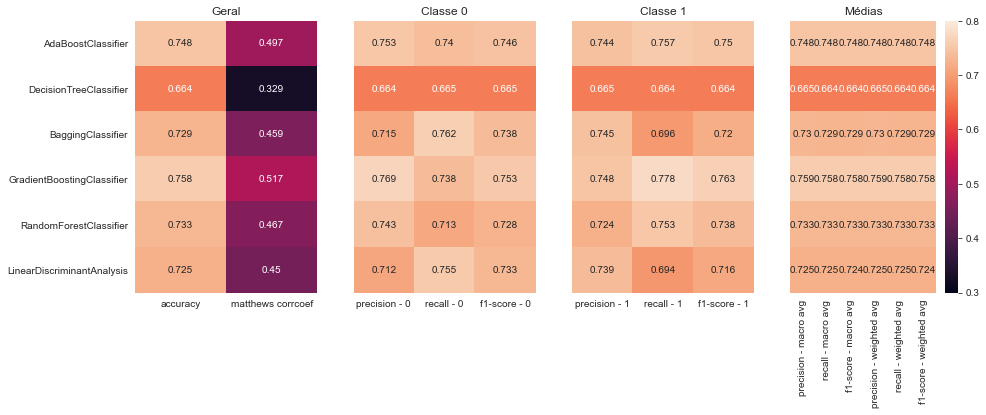

In [321]:
heatmap(regular_scr)

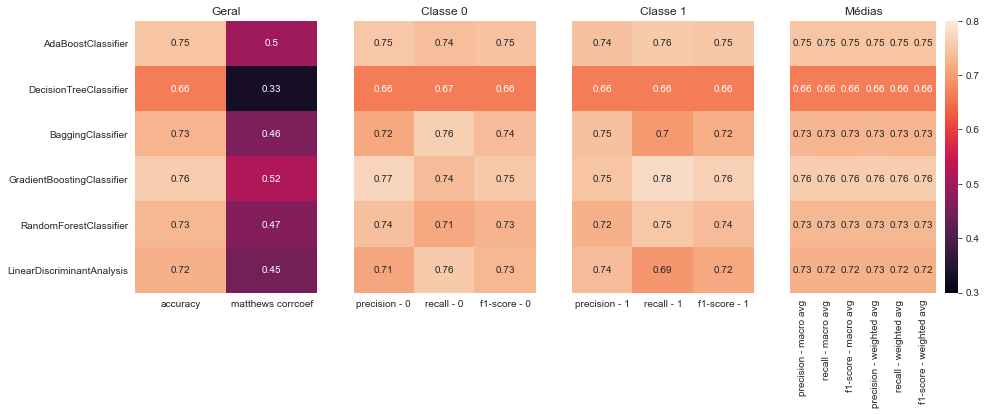

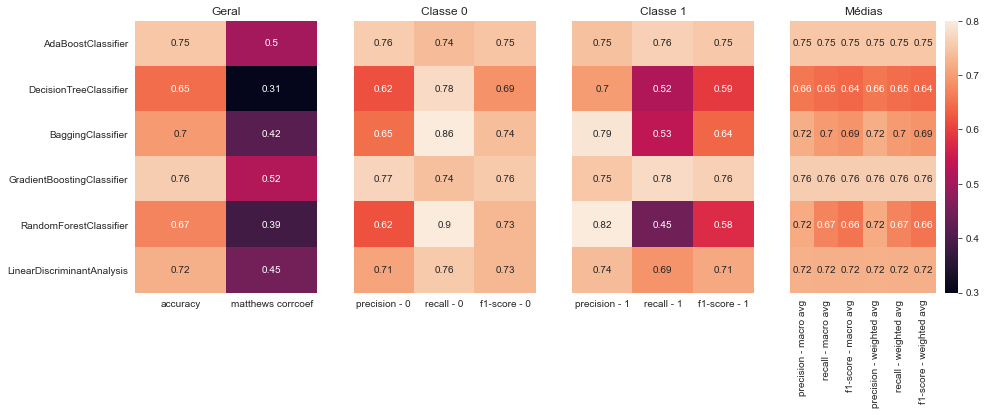

In [42]:
heatmap(regular_scr)
heatmap(over_scr)

In [611]:
imb_scrs = scr_models(train_bin, test_bin, target, imb_ensemble, imb_names, imb_params)


Avaliando Modelo RUSBoostClassifier - (4/4)

Construindo Modelo RUSBoostClassifier...
Fitting...
Predicting...
Scoring...


In [615]:
imb_true_scrs = scr_models(train_ext_true, test_bin, target, imb_ensemble, imb_names, imb_params)


Avaliando Modelo RUSBoostClassifier - (4/4)

Construindo Modelo RUSBoostClassifier...
Fitting...
Predicting...
Scoring...


In [614]:
train_true[target].value_counts()

NameError: name 'train_true' is not defined

In [612]:
imb_scrs

,accuracy,matthews corrcoef,precision - 0,recall - 0,f1-score - 0,precision - 1,recall - 1,f1-score - 1,precision - macro avg,recall - macro avg,f1-score - macro avg,precision - weighted avg,recall - weighted avg,f1-score - weighted avg
BalancedBaggingClassifier,0.7163,0.432896,0.708582,0.7348,0.721453,0.724611,0.6978,0.710953,0.716597,0.7163,0.716203,0.716597,0.7163,0.716203
BalancedRandomForestClassifier,0.7074,0.414853,0.710772,0.6994,0.705040,0.704134,0.7154,0.709722,0.707453,0.7074,0.707381,0.707453,0.7074,0.707381
EasyEnsembleClassifier,0.7350,0.470005,0.733971,0.7372,0.735582,0.736039,0.7328,0.734416,0.735005,0.7350,0.734999,0.735005,0.7350,0.734999
RUSBoostClassifier,0.7350,0.470005,0.733971,0.7372,0.735582,0.736039,0.7328,0.734416,0.735005,0.7350,0.734999,0.735005,0.7350,0.734999


In [616]:
imb_true_scrs

,accuracy,matthews corrcoef,precision - 0,recall - 0,f1-score - 0,precision - 1,recall - 1,f1-score - 1,precision - macro avg,recall - macro avg,f1-score - macro avg,precision - weighted avg,recall - weighted avg,f1-score - weighted avg
BalancedBaggingClassifier,0.7101,0.425782,0.680902,0.7908,0.731748,0.750537,0.6294,0.684651,0.715719,0.7101,0.708200,0.715719,0.7101,0.708200
BalancedRandomForestClassifier,0.7035,0.407011,0.702005,0.7072,0.704593,0.705017,0.6998,0.702399,0.703511,0.7035,0.703496,0.703511,0.7035,0.703496
EasyEnsembleClassifier,0.7376,0.475403,0.744747,0.7230,0.733712,0.730859,0.7522,0.741376,0.737803,0.7376,0.737544,0.737803,0.7376,0.737544
RUSBoostClassifier,0.7179,0.436234,0.708597,0.7402,0.724054,0.728072,0.6956,0.711466,0.718334,0.7179,0.717760,0.718334,0.7179,0.717760


In [656]:
Q_p = 1.8*1604*1e6; Q_p/1e9

2.8872000000000004

In [657]:
Q_e = 43.1*3600*24*365; Q_e/1e9

1.3592016

In [659]:
Q_t = Q_p - Q_e ; Q_t/1e9

1.5279984000000004

In [660]:
C = Q_e/Q_p

In [662]:
Q_t/1e9, C

(1.5279984000000004, 0.4707680798004987)

In [667]:
A = (0.9+0.9+1.2)

In [668]:
27*0.48*A/3.6

10.799999999999999

In [665]:
C = (0.32*0.3 + 0.28*0.9 + 0.91*1.2)/A

In [666]:
C

0.48000000000000004

# Outras Variaveis alvo

In [686]:
def filtrar_categorias(df, target, ctgr_lst, replace_dict=None, encode=False):
    
    print('Construindo Index...')       # Selecionando index onde alvo em 'ctgr_lst'
    new_index=[]
    for ctgr in ctgr_lst:
        new_index += df[df[target]==ctgr].index.tolist()
    
    print('Extraindo Dados da Tabela...')      # Extraindo tabela com index construído
    df = df.loc[new_index]    
    
    if type(replace_dict)!=type(None):
        print('Substituindo Categorias: {}'.format(replace_dict))      # Fusão de categorias
        for key in replace_dict.keys():
            df[target] = df[target].replace(key, replace_dict[key])
    
    if encode:
        print('Rotulando Variável Alvo...')
        df[target] = le().fit(df[target]).transform(df[target])      # Rotulando variável alvo
        
    print('\nCategorias Atualizadas!')
    return df

In [730]:
def feat_imp(df, target, test_size=0.2, random_state=None, n_models=1):

    feat_imp_models = [TREE, RFC, ETC, GBC, ABC][:n_models]
    feat_imp_names = ['TREE', 'RFC', 'ETC', 'GBC', 'ABC'][:n_models]
    
    y = df[target].copy()
    x = df.drop([target], axis=1)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=(1-test_size), random_state=random_state)

    feat_cols = x_train.columns.tolist()
    scrs = []
    lst = []
    for i in range(len(feat_imp_models)):

        print('({}/{}) {}'.format(i, len(feat_imp_names), feat_imp_names[i]))
        print('Fitting...')
        model = feat_imp_models[i]().fit(x_train, y_train)
        print('Predicting...')
        y_pred = model.predict(x_test)
        print('Scoring...')
        acc = acc_scr(y_test, y_pred)

        feat_imps = model.feature_importances_.tolist()
        lst.append([feat_imp_names[i]]+feat_imps)
        scrs.append([feat_imp_names[i], acc])

        clear_output(wait=True)

    scrs_df = pd.DataFrame(scrs, columns=['model_name', 'acc']).set_index('model_name')
    feat_df = pd.DataFrame(lst, columns=['model_name'] + feat_cols).set_index('model_name')

    return scrs_df, feat_df

In [742]:
def multi_sample_index(index, start=0.1, n_points=10, degree=2):
    
    n_indices = len(index)
    ps = np.linspace(start, 1, n_points)**degree
    sizes = [int(i) for i in ps*n_indices]
    
    new_indexes = []
    for size in sizes:
        new_indexes.append(np.random.choice(index, size, replace=False))
        
    return new_indexes

In [774]:
def size_tune(train_set, test_set, target, models, names, params_list=None, start=0.1, n_points=10, degree=2, concat_to=None):
    
    indexes = multi_sample_index(train_set.index, start, n_points, degree)
    n_ind = len(indexes)
    n_samples = len(indexes[-1])

    size_scrs = []
    cnt=1
    for index in indexes:
        
        sample_size = len(index)
        step_train = train_set.loc[index]
        clear_output(wait=True)
        print('Avaliando Amostra {}/{} Tamanho {}/{}'.format(cnt, n_ind, sample_size, n_samples))
        step_scr = scr_models(  step_train,
                                test_set,
                                target,
                                models,
                                names,
                                params_list,
                                clear=False  )
        
        step_scr['sample_size'] = sample_size
        size_scrs.append(step_scr)
        cnt+=1
        
    size_df = pd.concat(size_scrs)
    
    if type(concat_to)!=type(None): size_df = pd.concat([concat_to, size_df])
    
    return size_df

In [713]:
#dict_5ano = pd.read_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Personal Work\Data Frames\Source\saep\dicionários quest. alunos\dicionario 5ano.csv').set_index('questão')
dict_9ano = pd.read_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Personal Work\Data Frames\Source\saep\dicionários quest. alunos\dicionario 9ano.csv').set_index('questão')
#dict_3ano = pd.read_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Personal Work\Data Frames\Source\saep\dicionários quest. alunos\dicionario 3ano.csv').set_index('questão')

In [15]:
target = 'TX_RESP_Q050'

In [673]:
#target = 'TX_RESP_Q048'  # Reprovação 5º Ano
#target = 'TX_RESP_Q049'  # Abandono 5º Ano
target = 'TX_RESP_Q049'  # Reprovação 9º Ano
#target = 'TX_RESP_Q050'  # Abandono 9º Ano

In [23]:
ano9_base[target].value_counts()

NameError: name 'ano9_base' is not defined

In [745]:
rep_train, rep_test = binary_sample(ano9_base, target, categories=[[1,2],[3]], testing=[5000, 5000], training=[5000, 5000])

Contagem Categorias:


,Original,Treinamento,Teste
0,2470,NaN,NaN
1,188900,3385.0,3425.0
2,87886,1615.0,1575.0
3,35623,5000.0,5000.0



Nenhum Aluno em Comum nas Tabelas de Treinamento e Teste


In [746]:
rep_train = filtrar_categorias(rep_train, target, ctgr_lst=[1,2,3], replace_dict={1:0, 2:0, 3:1}, encode=True)

Construindo Index...
Extraindo Dados da Tabela...
Substituindo Categorias: {1: 0, 2: 0, 3: 1}
Rotulando Variável Alvo...

Categorias Atualizadas!


In [747]:
rep_test = filtrar_categorias(rep_test, target, ctgr_lst=[1,2,3], replace_dict={1:0, 2:0, 3:1}, encode=True)

Construindo Index...
Extraindo Dados da Tabela...
Substituindo Categorias: {1: 0, 2: 0, 3: 1}
Rotulando Variável Alvo...

Categorias Atualizadas!


In [22]:
[print(df[target].value_counts().to_frame()) for df in [rep_train, rep_test]]

NameError: name 'rep_train' is not defined

### Avaliando

# 5000 de cada

In [753]:
scrs = scr_models(rep_train, rep_test, target, models, models_names)


Avaliando Modelo LinearDiscriminantAnalysis - (6/6)

Construindo Modelo LinearDiscriminantAnalysis...
Fitting...
Predicting...
Scoring...


In [754]:
scrs

,accuracy,matthews corrcoef,precision - 0,recall - 0,f1-score - 0,precision - 1,recall - 1,f1-score - 1,precision - macro avg,recall - macro avg,f1-score - macro avg,precision - weighted avg,recall - weighted avg,f1-score - weighted avg
AdaBoostClassifier,0.8255,0.652414,0.848426,0.7926,0.819564,0.805404,0.8584,0.831058,0.826915,0.8255,0.825311,0.826915,0.8255,0.825311
DecisionTreeClassifier,0.7389,0.477825,0.736488,0.7440,0.740225,0.741362,0.7338,0.737562,0.738925,0.7389,0.738893,0.738925,0.7389,0.738893
BaggingClassifier,0.8130,0.626130,0.806742,0.8232,0.814888,0.819518,0.8028,0.811073,0.813130,0.8130,0.812981,0.813130,0.8130,0.812981
GradientBoostingClassifier,0.8287,0.658115,0.844766,0.8054,0.824613,0.814065,0.8520,0.832600,0.829415,0.8287,0.828607,0.829415,0.8287,0.828607
RandomForestClassifier,0.8139,0.628926,0.833865,0.7840,0.808164,0.796188,0.8438,0.819303,0.815027,0.8139,0.813733,0.815027,0.8139,0.813733
LinearDiscriminantAnalysis,0.7870,0.574245,0.778857,0.8016,0.790065,0.795632,0.7724,0.783844,0.787245,0.7870,0.786955,0.787245,0.7870,0.786955


In [755]:
importances = feat_imp(rep_train, target, n_models=6)

(4/5) ABC
Fitting...
Predicting...
Scoring...


In [756]:
importances[0]

,acc
model_name,
TREE,0.723750
RFC,0.792000
ETC,0.729000
GBC,0.820875
ABC,0.799250


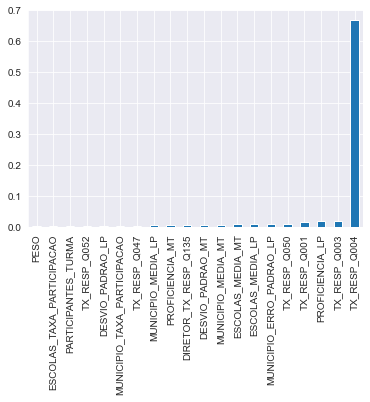

In [797]:
importances[1].loc['GBC'].sort_values().tail(20).plot.bar()

In [796]:
dict_9ano.loc['TX_RESP_Q001']

Enunciado          Sexo
A            Masculino.
B             Feminino.
C                   NaN
D                   NaN
E                   NaN
F                   NaN
G                   NaN
H                   NaN
I                   NaN
J                   NaN
K                   NaN
L                   NaN
Name: TX_RESP_Q001, dtype: object

In [775]:
rep_size_tune = size_tune(rep_train, rep_test, target, models, models_names)

Avaliando Amostra 10/10 Tamanho 10000/10000

Avaliando Modelo AdaBoostClassifier - (1/6)

Construindo Modelo AdaBoostClassifier...
Fitting...
Predicting...
Scoring...

Avaliando Modelo DecisionTreeClassifier - (2/6)

Construindo Modelo DecisionTreeClassifier...
Fitting...
Predicting...
Scoring...

Avaliando Modelo BaggingClassifier - (3/6)

Construindo Modelo BaggingClassifier...
Fitting...
Predicting...
Scoring...

Avaliando Modelo GradientBoostingClassifier - (4/6)

Construindo Modelo GradientBoostingClassifier...
Fitting...
Predicting...
Scoring...

Avaliando Modelo RandomForestClassifier - (5/6)

Construindo Modelo RandomForestClassifier...
Fitting...
Predicting...
Scoring...

Avaliando Modelo LinearDiscriminantAnalysis - (6/6)

Construindo Modelo LinearDiscriminantAnalysis...
Fitting...
Predicting...
Scoring...


In [800]:
scrs_cols = [rep_size_tune.columns[:-1].tolist()[a:b] for a, b in [[0,2], [2,5], [5,8], [8,14]]]

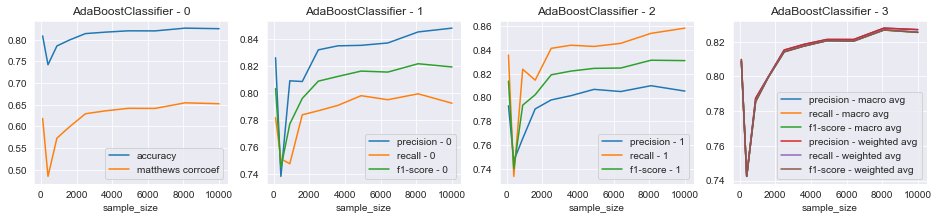

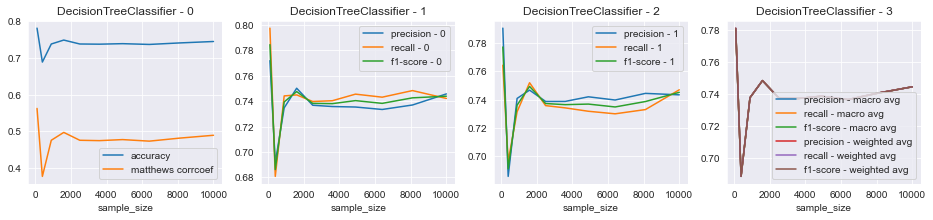

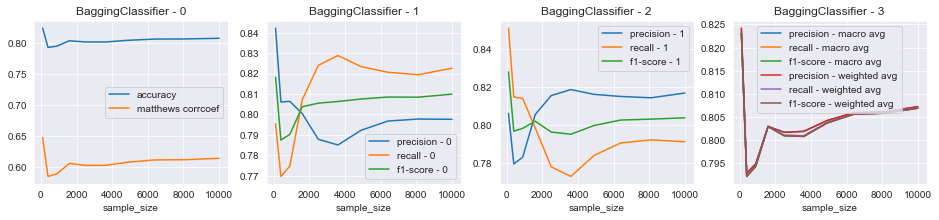

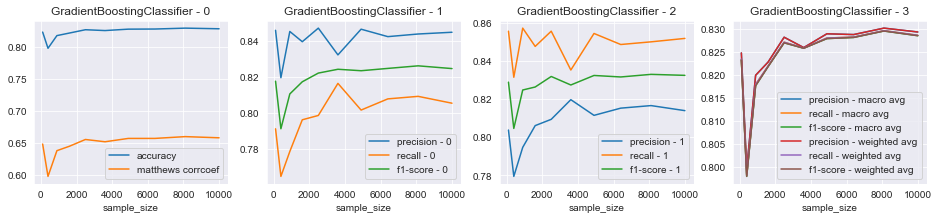

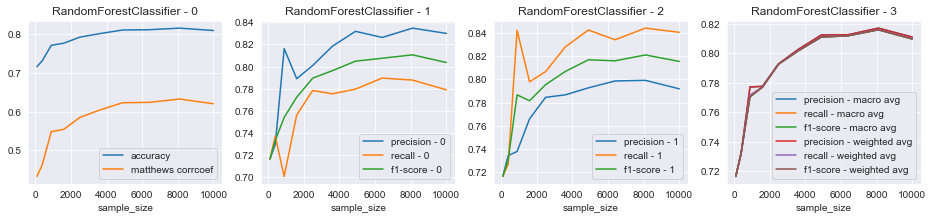

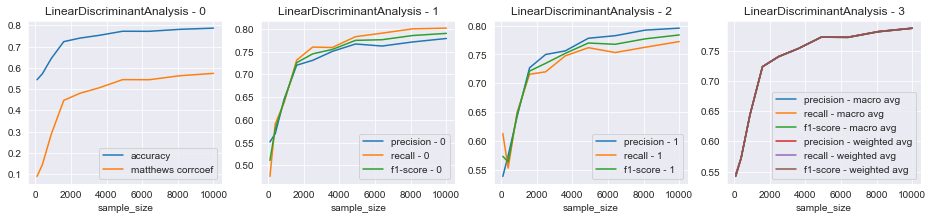

In [801]:
scrs_prog(rep_size_tune, key='sample_size', full=True, cols=scrs_cols)

In [740]:
feat_imp??

Signature: feat_imp(df, target, test_size=0.2, random_state=None, n_models=1)
Docstring: <no docstring>
Source:   
def feat_imp(df, target, test_size=0.2, random_state=None, n_models=1):

    feat_imp_models = [TREE, RFC, ETC, GBC, ABC][:n_models]
    feat_imp_names = ['TREE', 'RFC', 'ETC', 'GBC', 'ABC'][:n_models]
    
    y = df[target].copy()
    x = df.drop([target], axis=1)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=(1-test_size), random_state=random_state)

    feat_cols = x_train.columns.tolist()
    scrs = []
    lst = []
    for i in range(len(feat_imp_models)):

        print('({}/{}) {}'.format(i, len(feat_imp_names), feat_imp_names[i]))
        print('Fitting...')
        model = feat_imp_models[i]().fit(x_train, y_train)
        print('Predicting...')
        y_pred = model.predict(x_test)
        print('Scoring...')
        acc = acc_scr(y_test, y_pred)

        feat_imps = model.feature_importances_.tolist()
        lst.append([feat_imp_names